**NLP Project 1. Sentiment Analysis on Customer Reviews**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

In [ ]:
from collections import Counter

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline

In [ ]:
import pickle

**Section 1. part a. Load and Understanding the dataset**

In [ ]:
# load the data
data = pd.read_excel("Canva_reviews.xlsx")

In [ ]:
# take a peak at data
data.head(3)

,reviewId,userName,userImage,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,Sentiment,Sub Category,Sub Category_test
0,gp:AOqpTOFxf3fttcT5DSvFIn9KPp5FErgH9yC533Fmoxv...,Donna Caritero,https://play-lh.googleusercontent.com/a-/AOh14...,Overall it's really an amazing app. I've been ...,4,528,2.116.0,2021-06-17 07:18:54,Hi Donna. We are sorry that your text or desig...,2021-06-19 21:24:32,Negative,NaN,bug_picture_quality
1,gp:AOqpTOEq6rNIWLnPV4KFTctWvm0mpGEQljtD6mvy1H-...,Soumi Mukhopadhyay,https://play-lh.googleusercontent.com/a-/AOh14...,Hey! Yes I gave a 5 star rating... coz I belie...,5,351,2.116.0,2021-06-17 19:18:28,NaN,NaT,Positive,extremely_happy,NaN
2,gp:AOqpTOE86hSyPRHZgYt28Uk5zGe4FZGb1hkmtFDiYJ2...,Theknown _unknown,https://play-lh.googleusercontent.com/a-/AOh14...,Canva used to be a good app! But recently I've...,1,160,2.116.0,2021-06-23 19:13:28,Hi there. We're sorry to hear that you are hav...,2021-06-26 20:20:56,Negative,saving_downloading_issue,bug_saving_files


In [ ]:
print(data.columns)

Index(['reviewId', 'userName', 'userImage', 'review', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'Sentiment',
       'Sub Category', 'Sub Category_test'],
      dtype='object')


In [ ]:
# dimension of the dataset
data.shape

(1500, 13)

In [ ]:
# data types of columns / features
data.dtypes

,0
reviewId,object
userName,object
userImage,object
review,object
score,int64
thumbsUpCount,int64
reviewCreatedVersion,object
at,datetime64[ns]
replyContent,object
repliedAt,datetime64[ns]


**Checking Null Values**

In [ ]:
# total null values in each column
data.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
review,0
score,0
thumbsUpCount,0
reviewCreatedVersion,0
at,0
replyContent,977
repliedAt,977


**Checking one particular row**

In [ ]:
data.loc[13, "review"]

'Unable to save my work. Nothing works :('

In [ ]:
data.loc[13, "Sentiment"]

'Negative'

In [ ]:
print(data.iloc[[1495]])

                                               reviewId  userName  \
1495  gp:AOqpTOHhnXMpylU3f-1V1KbR2hwWArOilxPlKI6K4xY...  Reen Ali   

                                              userImage  \
1495  https://play-lh.googleusercontent.com/a-/AOh14...   

                                                review  score  thumbsUpCount  \
1495  Absolutely amazing and a lifesaver for teachers.      5              0   

     reviewCreatedVersion                  at replyContent repliedAt  \
1495              2.127.0 2021-09-07 02:45:51          NaN       NaT   

     Sentiment     Sub Category Sub Category_test  
1495  Positive  extremely_happy               NaN  


**Section 1 - part b. EDA**

**Count and percentage of Target variable**

In [ ]:
data["Sentiment"].describe()

,Sentiment
count,1500
unique,2
top,Positive
freq,1032


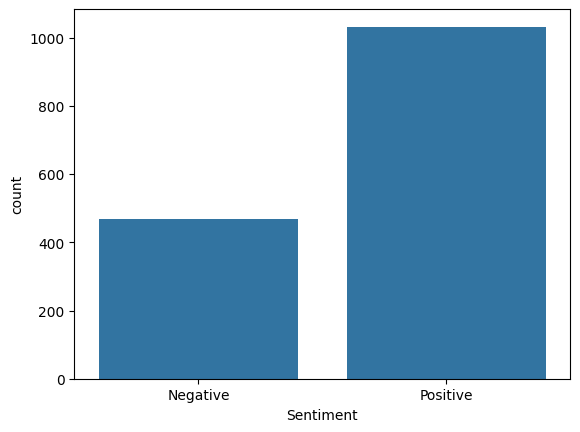

In [ ]:
sns.countplot(x="Sentiment", data=data)
plt.show()

In [ ]:
data["Sentiment"].value_counts()

,count
Sentiment,
Positive,1032
Negative,468


In [ ]:
468/(1032+468)

0.312

**Some more EDA**

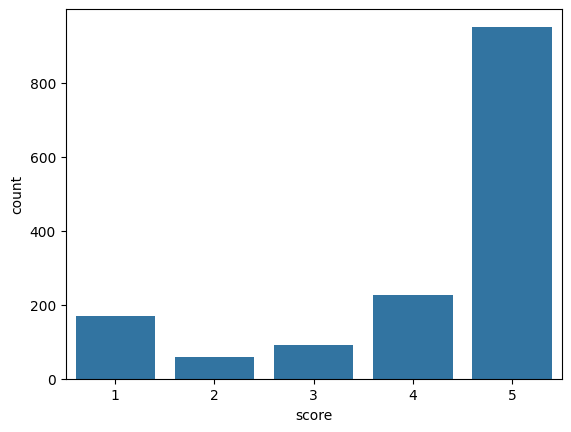

In [ ]:
# How is the feature 'score' distributed?
sns.countplot(x="score", data=data)
plt.show()

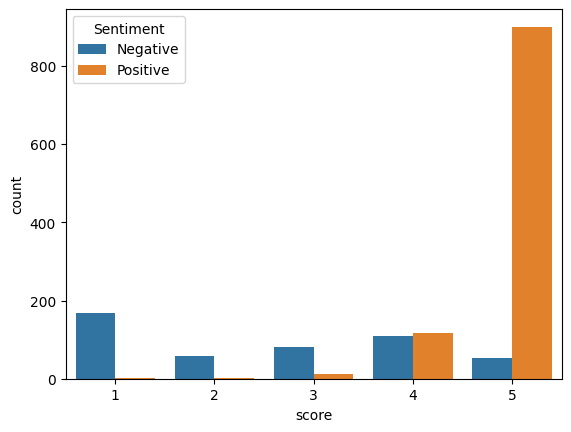

In [ ]:
# Is score related to sentiment?

sns.countplot(x="score", data=data, hue="Sentiment")
plt.show()

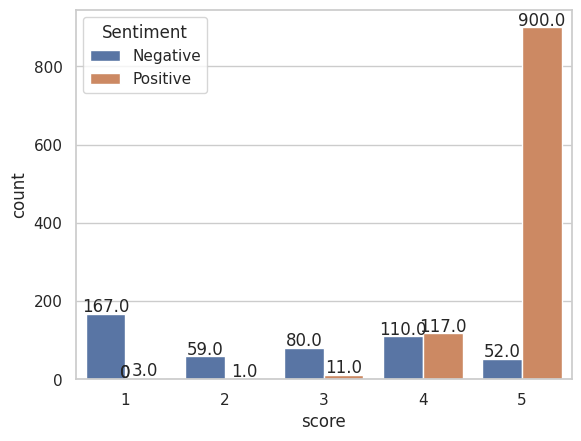

In [ ]:
# Same plot, but showing the counts per score
sns.set(style="whitegrid")
# Create the countplot
ax = sns.countplot(x="score", data=data, hue="Sentiment")
# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
# Show the plot
plt.show()

In [ ]:
# is review length related to sentiment?
# create a new column 'len' in the dataframe data
data["len"] = data["review"].apply(len)

In [ ]:
data["len"].describe()

,len
count,1500.000000
mean,86.468667
std,55.681355
min,20.000000
25%,54.000000
50%,75.000000
75%,102.000000
max,498.000000


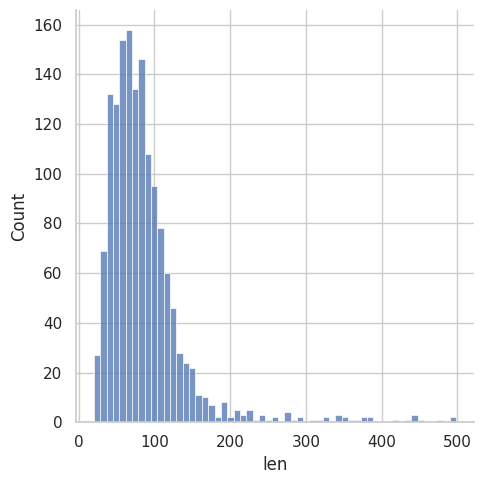

In [ ]:
sns.displot(data["len"])
plt.show()

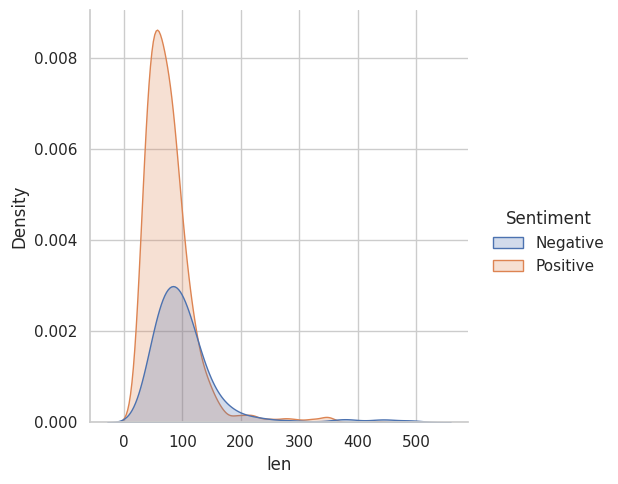

In [ ]:
sns.displot(data=data, x="len", hue="Sentiment", kind="kde", fill=True)
plt.show()


In [ ]:
data = data[["review", "Sentiment"]]

**Section 2. Data Preprocessing**

**1. Tokenization**

This is where our actual task begins. Since we only deal with review and Sentiment columns, we can get
rid of other variables.


In [ ]:
import nltk
nltk.download()


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_eng to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package averaged_perceptron_tagger_rus to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_rus.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_d


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
# go to add the required libraries from nltk now

In [ ]:
data.loc[13, "review"]


'Unable to save my work. Nothing works :('

In [ ]:
sent_tokenize(data.loc[13,"review"])

['Unable to save my work.', 'Nothing works :(']

In [ ]:
word_tokenize(data.loc[13, "review"])

['Unable', 'to', 'save', 'my', 'work', '.', 'Nothing', 'works', ':', '(']

In [ ]:
data.loc[1495, "review"]

'Absolutely amazing and a lifesaver for teachers.'

**2. Convert text to lower case**

In [ ]:
# copying the review column from the dataframe data in which we have only 2 columns
reviews = list(data["review"])

In [ ]:
#number of entries in the list review
len(reviews)


1500

In [ ]:
reviews[13]

'Unable to save my work. Nothing works :('

In [ ]:
reviews[1495]


'Absolutely amazing and a lifesaver for teachers.'

In [ ]:
reviews[1495].lower()

'absolutely amazing and a lifesaver for teachers.'

In [ ]:
reviews_lower = [r.lower() for r in reviews]

In [ ]:
reviews_lower[13]

'unable to save my work. nothing works :('

In [ ]:
reviews_lower = []
for r in reviews:
 reviews_lower.append(r.lower())

In [ ]:
# now we create another list of lists from revws
tokens = [word_tokenize(r) for r in reviews_lower]


In [ ]:
tokens[13]

['unable', 'to', 'save', 'my', 'work', '.', 'nothing', 'works', ':', '(']

In [ ]:
tokens[1495]

['absolutely', 'amazing', 'and', 'a', 'lifesaver', 'for', 'teachers', '.']

In [ ]:
len(tokens)

1500

So, we started with dataframe data. We copied its 'review' column in a list named 'review'. We created
another list 'review_lower' by lowering the case of all individual reviews. Lastly, we created another list in
which we word-tokenized each review. So, every entry of the list tokens is a list of tokenized words.

**3. Stopwords removal**

In [ ]:
sw = stopwords.words('english')

In [ ]:
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
tokens[13]

['unable', 'to', 'save', 'my', 'work', '.', 'nothing', 'works', ':', '(']

In [ ]:
tokens = [[word for word in t if word not in sw] for t in tokens]

In [ ]:
tokens[13]

['unable', 'save', 'work', '.', 'nothing', 'works', ':', '(']

**4. Punctuation removal**


In [ ]:
# regular expression r'\w+' removes any punctuation marks
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
# let's check how it works
tokenizer.tokenize("isn't")

['isn', 't']

In [ ]:
# tokenize() function in tokenizer module returns a list. This is a problem given
# a list of lists (tokens). So, each list items of lists into another list will be
# So, we will join the tokens if they are separated due to punctuation.
t = tokenizer.tokenize("won't")
"".join(t)

'wont'

In [ ]:
tokenizer.tokenize(":")

[]

In [ ]:
# the main work
tokens = [["".join(tokenizer.tokenize(word)) for word in t
 if len(tokenizer.tokenize(word))>0] for t in tokens]


In [ ]:
reviews[248]

"It won't download at all for me to send it to others via text, email, etc"

In [ ]:
tokens[248]

['wo', 'nt', 'download', 'send', 'others', 'via', 'text', 'email', 'etc']

In [ ]:
# problem: won't did not join !! check !!

**5. Stemming**

In [ ]:
porter = PorterStemmer()
lancaster = LancasterStemmer()

In [ ]:
print(porter.stem("teachers"))
print(lancaster.stem("teachers"))

teacher
teach


In [ ]:
print(porter.stem("students"))
print(lancaster.stem("students"))


student
stud


In [ ]:
print(porter.stem("absolutely"))
print(lancaster.stem("absolutely"))

absolut
absolv


In [ ]:
tokens = [[porter.stem(word) for word in t] for t in tokens]


In [ ]:
print(reviews[13])
print(tokens[13])


Unable to save my work. Nothing works :(
['unabl', 'save', 'work', 'noth', 'work']


In [ ]:
print(reviews[1495])
print(tokens[1495])

Absolutely amazing and a lifesaver for teachers.
['absolut', 'amaz', 'lifesav', 'teacher']


**Section 3. Word Count Districution**

In [ ]:
tokens[0:10]


[['overal',
  's',
  'realli',
  'amaz',
  'app',
  've',
  'use',
  'past',
  '5',
  'year',
  'howev',
  'one',
  'issu',
  'though',
  'want',
  'get',
  'address',
  'sinc',
  'think',
  'issu',
  'last',
  'mani',
  'year',
  'text',
  'blur',
  'zoom',
  's',
  'pixel',
  'thought',
  'issu',
  'occur',
  'mobil',
  'app',
  'howev',
  'also',
  'present',
  'websit',
  'pleas',
  'fix',
  'still',
  'rememb',
  'time',
  'export',
  'high',
  'definit',
  'text',
  'love',
  'experi',
  'thank'],
 ['hey',
  'ye',
  'gave',
  '5',
  'star',
  'rate',
  'coz',
  'believ',
  'deserv',
  'mostli',
  'use',
  'desktop',
  'version',
  'serious',
  'satisfi',
  'app',
  'android',
  'desktop',
  'version',
  'came',
  'thank',
  'develop',
  'beauti',
  'app',
  'facil',
  'liter',
  'find',
  'almost',
  'everyth',
  'need',
  'best',
  'part',
  'even',
  'without',
  'premium',
  'featur',
  'provid',
  'us',
  'lot',
  'mani',
  'facil',
  'love',
  'thank'],
 ['canva',
  'use',
 

In [ ]:
# We need to find uniques tokens in all the 1500 list of tokens for which we need
# It will create 1 list of tokens, instead of list of lists of tokens
flat_tokens = [word for t in tokens for word in t]


In [ ]:
flat_tokens[0:200]


['overal',
 's',
 'realli',
 'amaz',
 'app',
 've',
 'use',
 'past',
 '5',
 'year',
 'howev',
 'one',
 'issu',
 'though',
 'want',
 'get',
 'address',
 'sinc',
 'think',
 'issu',
 'last',
 'mani',
 'year',
 'text',
 'blur',
 'zoom',
 's',
 'pixel',
 'thought',
 'issu',
 'occur',
 'mobil',
 'app',
 'howev',
 'also',
 'present',
 'websit',
 'pleas',
 'fix',
 'still',
 'rememb',
 'time',
 'export',
 'high',
 'definit',
 'text',
 'love',
 'experi',
 'thank',
 'hey',
 'ye',
 'gave',
 '5',
 'star',
 'rate',
 'coz',
 'believ',
 'deserv',
 'mostli',
 'use',
 'desktop',
 'version',
 'serious',
 'satisfi',
 'app',
 'android',
 'desktop',
 'version',
 'came',
 'thank',
 'develop',
 'beauti',
 'app',
 'facil',
 'liter',
 'find',
 'almost',
 'everyth',
 'need',
 'best',
 'part',
 'even',
 'without',
 'premium',
 'featur',
 'provid',
 'us',
 'lot',
 'mani',
 'facil',
 'love',
 'thank',
 'canva',
 'use',
 'good',
 'app',
 'recent',
 've',
 'face',
 'issu',
 'save',
 'file',
 'want',
 'file',
 'save',

In [ ]:
# number of flattened tokens
len(flat_tokens)


13782

In [ ]:
# import a counter on the top section
counts = Counter(flat_tokens)

In [ ]:
type(counts)


collections.Counter

In [ ]:
len(counts) # number of unique tokens

1720

In [ ]:
counts.most_common(10)

[('app', 932),
 ('use', 474),
 ('design', 349),
 ('easi', 293),
 ('s', 240),
 ('love', 220),
 ('good', 219),
 ('edit', 191),
 ('make', 190),
 ('great', 184)]

In [ ]:
# if we didn't do stemming etc., this number 1720 would be higher
# next, we need to convert these tokens into numbers

**Section 4. Binary Bag of Words**

In [ ]:
tokens[13]

['unabl', 'save', 'work', 'noth', 'work']

In [ ]:
" ".join(tokens[13])

'unabl save work noth work'

In [ ]:
clean_reviews = [" ".join(t) for t in tokens]

In [ ]:
clean_reviews[13]

'unabl save work noth work'

In [ ]:
clean_reviews[1495]

'absolut amaz lifesav teacher'

In [ ]:
# binary bag of words with a minimum of 1 token in 5 lines/times
vect = CountVectorizer(binary=True, min_df=5)


In [ ]:
X = vect.fit_transform(clean_reviews)

In [ ]:
X.shape

(1500, 413)

In [ ]:
# so out of 1720, only 413 tokens are avaible in 5 or more docs

In [ ]:
# to see all vocabulary
vect.vocabulary_


{'overal': 243,
 'realli': 289,
 'amaz': 17,
 'app': 24,
 've': 381,
 'use': 377,
 'past': 246,
 'year': 409,
 'howev': 167,
 'one': 237,
 'issu': 182,
 'though': 358,
 'want': 385,
 'get': 148,
 'sinc': 315,
 'think': 357,
 'last': 192,
 'mani': 214,
 'text': 354,
 'zoom': 412,
 'thought': 359,
 'mobil': 221,
 'also': 15,
 'present': 270,
 'websit': 390,
 'pleas': 262,
 'fix': 132,
 'still': 333,
 'time': 361,
 'export': 119,
 'high': 164,
 'definit': 82,
 'love': 209,
 'experi': 117,
 'thank': 355,
 'gave': 147,
 'star': 331,
 'rate': 286,
 'deserv': 83,
 'desktop': 85,
 'version': 382,
 'satisfi': 301,
 'android': 18,
 'develop': 86,
 'beauti': 40,
 'liter': 200,
 'find': 128,
 'almost': 12,
 'everyth': 113,
 'need': 228,
 'best': 43,
 'even': 109,
 'without': 397,
 'premium': 268,
 'featur': 125,
 'provid': 280,
 'us': 376,
 'lot': 208,
 'canva': 55,
 'good': 152,
 'recent': 290,
 'face': 120,
 'save': 302,
 'file': 127,
 'stuck': 336,
 'download': 94,
 'call': 52,
 'magic': 212,
 

In [ ]:
# to see number of unique vectors
len(vect.vocabulary_)


413

**Convert this sparse matrix to array**

In [ ]:
type(X)


scipy.sparse._csr.csr_matrix

In [ ]:
X_a = X.toarray()
X_a.shape

(1500, 413)

In [ ]:
X_a[13,:]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
X_a[13,:].sum()

4

In [ ]:
clean_reviews[13]

'unabl save work noth work'

In [ ]:
feature_names = vect.get_feature_names_out()
token = "unabl"
if token in feature_names:
 index = list(feature_names).index(token)
 print(f"Index of '{token}': {index}")
else:
 print(f"'{token}' not found in feature names.")

Index of 'unabl': 370


In [ ]:
token = "work"
if token in feature_names:
 index = list(feature_names).index(token)
 print(f"Index of '{token}': {index}")
else:
 print(f"'{token}' not found in feature names.")

Index of 'work': 401


In [ ]:
X_a[13,401]

1

In [ ]:
data.head()

,review,Sentiment
0,Overall it's really an amazing app. I've been ...,Negative
1,Hey! Yes I gave a 5 star rating... coz I belie...,Positive
2,Canva used to be a good app! But recently I've...,Negative
3,"It's a brilliant app, but I have just one prob...",Negative
4,This was such a great app. I used to make BTS ...,Negative


In [ ]:
# encode
data["Sentiment"] = data["Sentiment"].apply(lambda x: 1 if x=="Positive" else 0)

In [ ]:
# encode - another, easy version
# Encode 'Sentiment' column
#data['Sentiment_Encoded'] = data['Sentiment'].map({'Negative': 0, 'Positive': 1})

In [ ]:
y = data["Sentiment"]

**Section 4.1. Model Building using Binary Bag of Words**


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
 stratify=y, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
train_pred = model.predict(X_train)


In [ ]:
accuracy_score(y_train, train_pred)

0.9608333333333333

In [ ]:
test_pred = model.predict(X_test)
accuracy_score(y_test, test_pred)

0.8933333333333333

In [ ]:
import os
import pickle

# Create the output directory
os.makedirs("Output", exist_ok=True)

# Save the vectorizer and the model
with open("Output/binary_count_vect.pkl", "wb") as f:
    pickle.dump(vect, f)
with open("Output/binary_count_vect_lr.pkl", "wb") as f:
    pickle.dump(model, f)

**Section 5. Count Bag of Words and Model with it**

In [ ]:
vect = CountVectorizer(min_df=5)
X = vect.fit_transform(clean_reviews)

In [ ]:
X_a = X.toarray()

In [ ]:
clean_reviews[13]

'unabl save work noth work'

In [ ]:
feature_names = vect.get_feature_names_out()
token = "work"
if token in feature_names:
 index = list(feature_names).index(token)
 print(f"Index of '{token}': {index}")
else:
 print(f"'{token}' not found in feature names.")


Index of 'work': 401


In [ ]:
X_a[13,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
X_a[13,401]

2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
 stratify=y, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"Train Accuracy:{accuracy_score(y_train, train_pred)}")
print(f"Test Accuracy:{accuracy_score(y_test, test_pred)}")

Train Accuracy:0.9558333333333333
Test Accuracy:0.8833333333333333


In [ ]:
with open("Output/count_vect.pkl", "wb") as f:
 pickle.dump(vect, f)
with open("Output/count_vect_lr.pkl", "wb") as f:
 pickle.dump(model, f)

**Section 6. N-grams Bag of Words and Model with it**


In [ ]:
vect = CountVectorizer(min_df=5, ngram_range=(1,3))
X = vect.fit_transform(clean_reviews)

In [ ]:
X.shape

(1500, 666)

In [ ]:
vect.vocabulary_


{'overal': 425,
 'realli': 476,
 'amaz': 19,
 'app': 29,
 've': 625,
 'use': 602,
 'past': 428,
 'year': 661,
 'howev': 298,
 'one': 415,
 'issu': 314,
 'though': 579,
 'want': 633,
 'get': 257,
 'sinc': 519,
 'think': 578,
 'last': 326,
 'mani': 372,
 'text': 573,
 'zoom': 665,
 'thought': 580,
 'mobil': 385,
 'also': 17,
 'present': 455,
 'websit': 638,
 'pleas': 446,
 'fix': 237,
 'still': 539,
 'time': 582,
 'export': 219,
 'high': 293,
 'definit': 155,
 'love': 350,
 'experi': 217,
 'thank': 574,
 'realli amaz': 477,
 'amaz app': 20,
 'app ve': 66,
 've use': 628,
 'pleas fix': 447,
 'gave': 255,
 'star': 537,
 'rate': 472,
 'deserv': 156,
 'desktop': 164,
 'version': 629,
 'satisfi': 499,
 'android': 23,
 'develop': 166,
 'beauti': 86,
 'liter': 335,
 'find': 231,
 'almost': 14,
 'everyth': 212,
 'need': 395,
 'best': 89,
 'even': 206,
 'without': 645,
 'premium': 453,
 'featur': 227,
 'provid': 466,
 'us': 601,
 'lot': 346,
 'gave star': 256,
 'desktop version': 165,
 'canva': 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
 stratify=y, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"Train Accuracy:{accuracy_score(y_train, train_pred)}")
print(f"Test Accuracy:{accuracy_score(y_test, test_pred)}")


Train Accuracy:0.9708333333333333
Test Accuracy:0.8933333333333333


In [ ]:
with open("Output/n_gram.pkl", "wb") as f:
 pickle.dump(vect, f)
with open("Output/n_gram_lr.pkl", "wb") as f:
 pickle.dump(model, f)

**Section 7. TF-IDF and Model with it**

In [ ]:
vect = TfidfVectorizer(min_df=5)

In [ ]:
X = vect.fit_transform(clean_reviews)

In [ ]:
X.shape

(1500, 413)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
 stratify=y, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [ ]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"Train Accuracy:{accuracy_score(y_train, train_pred)}")
print(f"Test Accuracy:{accuracy_score(y_test, test_pred)}")

Train Accuracy:0.9341666666666667
Test Accuracy:0.8766666666666667


In [ ]:
with open("Output/tf-idf.pkl", "wb") as f:
 pickle.dump(vect, f)
with open("Output/tf-idf_lr.pkl", "wb") as f:
 pickle.dump(model, f)

**Section 8. Prediction on new data**

In [ ]:
# Sample test reviews
test_review_1 = '''this is a truly amazing app , best for those who havw
content but don't know how to express it in a good and shareable manner.
Thanks Team Canva for such a great app.'''
test_review_2 = '''Its the worst app ever I save my design lts not save'''
test_review_3 = 'Difficult to use. The interface is not user-friendly. No good for'

In [ ]:
#Load the best model (n-gram) and its vectorizer
vect = pickle.load(open("Output/n_gram.pkl", "rb"))
model = pickle.load(open("Output/n_gram_lr.pkl", "rb"))


In [ ]:
# Convert the reviews to a batch of one record
test_review_1 = [test_review_1]
test_review_2 = [test_review_2]
test_review_3 = [test_review_3]

In [ ]:
type(test_review_1)
print(test_review_1)

["this is a truly amazing app , best for those who havw\ncontent but don't know how to express it in a good and shareable manner.\nThanks Team Canva for such a great app."]


In [ ]:
test_review_1 = [r.lower() for r in test_review_1]
test_review_2 = [r.lower() for r in test_review_2]
test_review_3 = [r.lower() for r in test_review_3]

In [ ]:
tokens_1 = [word_tokenize(r) for r in test_review_1]
tokens_2 = [word_tokenize(r) for r in test_review_2]
tokens_3 = [word_tokenize(r) for r in test_review_3]

In [ ]:
tokens_1 = [[word for word in t if word not in sw] for t in tokens_1]
tokens_2 = [[word for word in t if word not in sw] for t in tokens_2]
tokens_3 = [[word for word in t if word not in sw] for t in tokens_3]

In [ ]:
tokens_1 = [["".join(tokenizer.tokenize(word)) for word in t
 if len(tokenizer.tokenize(word))>0] for t in tokens_1]
tokens_2 = [["".join(tokenizer.tokenize(word)) for word in t
 if len(tokenizer.tokenize(word))>0] for t in tokens_2]
tokens_3 = [["".join(tokenizer.tokenize(word)) for word in t
 if len(tokenizer.tokenize(word))>0] for t in tokens_3]

In [ ]:
tokens_1 = [[porter.stem(word) for word in t] for t in tokens_1]
tokens_2 = [[porter.stem(word) for word in t] for t in tokens_2]
tokens_3 = [[porter.stem(word) for word in t] for t in tokens_3]

In [ ]:
clean_review_1 = [" ".join(review) for review in tokens_1]
clean_review_2 = [" ".join(review) for review in tokens_2]
clean_review_3 = [" ".join(review) for review in tokens_3]

In [ ]:
X_test = vect.transform(clean_review_1)
print(X_test.shape)
print(model.predict_proba(X_test)) # probability for class 0 (negative) and class 1
print(model.predict(X_test))


(1, 666)
[[0.00443387 0.99556613]]
[1]


In [ ]:
X_test = vect.transform(clean_review_2)
print(X_test.shape)
print(model.predict_proba(X_test)) # probability for class 0 (negative) and class 1
print(model.predict(X_test))

(1, 666)
[[0.87712216 0.12287784]]
[0]


In [ ]:
X_test = vect.transform(clean_review_3)
print(X_test.shape)
print(model.predict_proba(X_test)) # probability for class 0 (negative) and class 1
print(model.predict(X_test))

(1, 666)
[[0.74332161 0.25667839]]
[0]
